In [1]:
import torch as t
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

from my_transformer import TransformerConfig, DecoderOnlyTransformer

In [2]:
class CustomTextDataset(Dataset):
    def __init__(self, vocab_size: int, seq_len: int, datasize: int):
        self.seqs = t.randint(0, vocab_size, (datasize, seq_len))

    def __len__(self):
            return len(self.seqs)

    def __getitem__(self, idx):
            input = self.seqs[idx]
            target = t.flip(input, dims=(0,))
            return (input, target)

In [3]:
config = TransformerConfig(
    num_layers=2,
    num_heads=8,
    vocab_size=20,
    hidden_size=96,
    max_seq_len=6,
    dropout=0.1,
    layer_norm_epsilon=1e-05
)

trainset = CustomTextDataset(vocab_size=config.vocab_size, seq_len=config.max_seq_len, datasize=100)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)


In [4]:
# Take a peak at an (input, target) pair from the trainloader
trainloader.dataset[0]

(tensor([17,  7,  1, 13, 11,  9]), tensor([ 9, 11, 13,  1,  7, 17]))

In [5]:
model = DecoderOnlyTransformer(config)
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []

In [6]:
NUM_EPOCHS = 250

model.train()
for epoch in range(1, NUM_EPOCHS + 1):
    for inputs, targets in trainloader:
        
        outputs = model(inputs)
        
        loss = criterion(
            rearrange(outputs, 'batch seq vocab -> (batch seq) vocab'),
            rearrange(targets, 'batch seq -> (batch seq)')
        )
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

<AxesSubplot:>

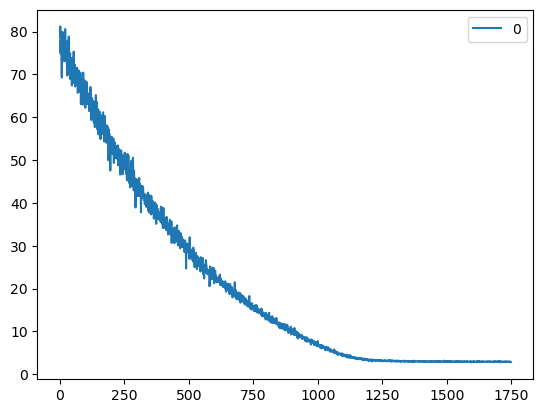

In [7]:
import pandas as pd
pd.DataFrame(train_losses).plot()

In [8]:
model.eval()
for i in range(10):
    with t.no_grad():
        input, target = trainset[i]
        output = model(input).argmax(dim=-1)
        print(input, output, target)

tensor([17,  7,  1, 13, 11,  9]) tensor([ 9,  7, 19,  9,  8,  9]) tensor([ 9, 11, 13,  1,  7, 17])
tensor([12,  4,  9,  3,  3,  3]) tensor([12,  4,  9,  3,  3,  3]) tensor([ 3,  3,  3,  9,  4, 12])
tensor([15,  8,  8, 10,  7, 19]) tensor([15,  8,  8, 10,  7, 19]) tensor([19,  7, 10,  8,  8, 15])
tensor([ 9, 11,  4,  1, 10,  2]) tensor([ 9, 19,  4, 19, 10,  2]) tensor([ 2, 10,  1,  4, 11,  9])
tensor([11,  3,  7, 16,  8, 13]) tensor([19,  3,  7, 16,  8,  9]) tensor([13,  8, 16,  7,  3, 11])
tensor([ 8,  7, 19, 11, 17, 10]) tensor([ 8,  7, 19,  8,  9, 10]) tensor([10, 17, 11, 19,  7,  8])
tensor([ 2, 13,  9, 17,  9, 19]) tensor([ 2,  9,  9,  9,  9, 19]) tensor([19,  9, 17,  9, 13,  2])
tensor([9, 2, 6, 0, 5, 4]) tensor([9, 2, 6, 5, 5, 4]) tensor([4, 5, 0, 6, 2, 9])
tensor([11, 17,  4, 17, 12, 16]) tensor([19,  9,  4,  9, 12, 16]) tensor([16, 12, 17,  4, 17, 11])
tensor([12,  3,  5,  9, 13, 16]) tensor([12,  3,  5,  9,  9, 16]) tensor([16, 13,  9,  5,  3, 12])
